Number of Gaussians: 1, AIC: -433.5757693226061
Number of Gaussians: 2, AIC: -493.69855461908975
Number of Gaussians: 3, AIC: -545.3628445782331
Number of Gaussians: 4, AIC: -526.7728236760788
Number of Gaussians: 5, AIC: -538.8549226646207
Best number of Gaussians: 3


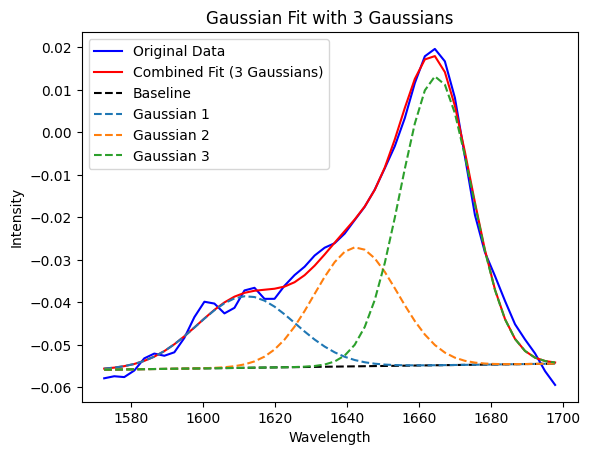

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from my_func.Read_ibw import read_ibw  # 実際のデータ読み込み関数

# ガウスフィット関数（n個のガウス関数の混合）
def gaussoffset_mixture(x, *params):
    num_gaussians = len(params) // 3
    result = params[0] + params[1] * x  # ベースライン (w0 + w1 * x)
    gaussians = []
    for i in range(num_gaussians):
        amp = params[2 + 3 * i]     # 振幅
        center = params[3 + 3 * i]  # 中心
        width = params[4 + 3 * i]   # 幅
        gauss = amp * np.exp(-((x - center) / width) ** 2)
        gaussians.append(gauss)
        result += gauss
    return result, gaussians

# コスト関数（フィッティング用）
def cost_function(params, x, y):
    fit_result, _ = gaussoffset_mixture(x, *params)
    return np.sum((fit_result - y) ** 2)

# フィッティングを行う関数
def perform_fit(x, y, num_gaussians):
    bounds = [(-0.1, 0.1), (-0.5, 0.5)]  # w0, w1 (ベースライン)
    for _ in range(num_gaussians):
        bounds.extend([(0.01, 0.1), (1600, 1700), (5, 20)])  # 振幅、中心、幅
    
    # 焼きなまし法でフィットを実行
    result = dual_annealing(cost_function, bounds, args=(x, y))
    return result.x

# AICの計算
def calculate_aic(x, y, params):
    fit_result, _ = gaussoffset_mixture(x, *params)
    residuals = y - fit_result
    rss = np.sum(residuals ** 2)  # 残差平方和
    n = len(y)                    # データ点の数
    k = len(params)               # パラメータ数
    aic = 2 * k + n * np.log(rss / n)
    return aic

# フィッティングとAICの計算を複数のガウス数で行う
def find_optimal_num_gaussians(x, y, max_gaussians=5):
    best_num_gaussians = None
    best_aic = np.inf
    best_params = None
    
    for num_gaussians in range(1, max_gaussians + 1):
        params = perform_fit(x, y, num_gaussians)
        aic = calculate_aic(x, y, params)
        print(f"Number of Gaussians: {num_gaussians}, AIC: {aic}")
        
        if aic < best_aic:
            best_aic = aic
            best_num_gaussians = num_gaussians
            best_params = params
    
    return best_num_gaussians, best_params

# フィッティング結果と個々のガウス関数、ベースラインをプロット
def plot_fit_and_components(x, y, params, num_gaussians):
    fit_result, gaussians = gaussoffset_mixture(x, *params)
    
    # ベースラインの計算
    w0, w1 = params[0], params[1]
    baseline = w0 + w1 * x
    
    # プロット
    plt.plot(x, y, 'b-', label='Original Data', markersize=4)
    plt.plot(x, fit_result, 'r-', label=f'Combined Fit ({num_gaussians} Gaussians)')
    plt.plot(x, baseline, 'k--', label='Baseline')

    # 各ガウス関数のプロット
    for i, gauss in enumerate(gaussians):
        plt.plot(x, baseline + gauss, '--', label=f'Gaussian {i+1}')
    
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title(f'Gaussian Fit with {num_gaussians} Gaussians')
    plt.show()

# 実際のデータを使ってフィッティングを行う部分
def main():
    # データの読み込み (以前のコードで使っていた .ibw ファイルから読み込む)
    data = np.moveaxis(read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_imchi3_dataOrig.ibw'), 0, -1)
    wavelengths = read_ibw('/Users/ootahiroki/Library/CloudStorage/Box-Box/KanoLab/Raman/data/1008H38_151_201_re_ramanshift2.ibw')

    # 特定の波長範囲を抽出
    start_wavelength = 1570
    end_wavelength = 1700
    mask = (wavelengths >= start_wavelength) & (wavelengths <= end_wavelength)
    selected_wavelengths = wavelengths[mask]
    
    # 特定の領域のスペクトルを選択してフィッティングする
    y1, y2, x1, x2 = 50, 180, 100, 150  # 選択する領域の範囲
    selected_data = data[y1:y2, x1:x2, 0, mask]
    avg_spectrum = np.mean(selected_data, axis=(0, 1))

    # 最適なガウス数を見つける
    best_num_gaussians, best_params = find_optimal_num_gaussians(selected_wavelengths, avg_spectrum, max_gaussians=5)
    print(f"Best number of Gaussians: {best_num_gaussians}")

    # 最適なフィットと各成分をプロット
    plot_fit_and_components(selected_wavelengths, avg_spectrum, best_params, best_num_gaussians)

if __name__ == "__main__":
    main()
